In [1]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.stattools import grangercausalitytests, adfuller
from tqdm import tqdm_notebook
from itertools import product

import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

pay = pd.read_csv('Data/Average Hourly Income by Gender.csv')
gender = pd.read_csv('Data/Total Employment.csv')
unemployment = pd.read_csv('Data/Total Unemployed.csv')

pay_subset = pay.iloc[3:141,].reset_index()
gender_subset = gender.iloc[3:141,].reset_index()
unemployment_subset = unemployment.iloc[14:152,].reset_index()

combined = pd.DataFrame()

combined['Date'] = pay_subset['Average Hourly Earnings  by Sector and Sex (Qrtly-Mar/Jun/Sep/Dec)']
combined['Male Average Hourly Pay'] = pay_subset['Unnamed: 1']
combined['Female Average Hourly Pay'] = pay_subset['Unnamed: 2']
combined['Total Males Employed'] = gender_subset['Unnamed: 1']
combined['Total Females Employed'] = gender_subset['Unnamed: 2']
combined['Total Both Sexes Employed'] = gender_subset['Unnamed: 3']
combined['Total Unemployment Male'] = unemployment_subset['Unnamed: 1']
combined['Total Unemployment Female'] = unemployment_subset['Unnamed: 2'] 
combined['Total Unemployment Both Sexes'] = unemployment_subset['Unnamed: 3'] 




combined["Date"] = pd.to_datetime(combined["Date"])
combined = combined.set_index('Date')
offset = pd.DateOffset(months=2)

# Apply the offset to the 'Date' column to move the dates forward by 3 months
combined.index = combined.index + offset

combined = combined.apply(pd.to_numeric, errors='coerce')

combined['Total Unemployment Male'] *= 1000
combined['Total Unemployment Female'] *= 1000
combined['Total Unemployment Both Sexes'] *= 1000

combined['Pay Gap (%)'] = ((combined['Male Average Hourly Pay'] - combined['Female Average Hourly Pay']) / combined['Male Average Hourly Pay'] ) * 100
combined['Male Proportion Employed (%)'] = ((combined['Total Males Employed']/combined['Total Both Sexes Employed'])) * 100
combined['Female Proportion Employed (%)'] = ((combined['Total Females Employed']/combined['Total Both Sexes Employed'])) * 100

combined['Unemployment Rate (%)'] = (combined['Total Unemployment Both Sexes']/(combined['Total Unemployment Both Sexes']+combined['Total Both Sexes Employed'])) * 100




### Vector Autogression of the New Zealand Gender Pay Gap, Proportion of Gender Employed & Unemployment Rate

### Jacob French (300572009), Oxana Hart, Pip Owles

#### 10/10/2023

### Executive Summary

**Research Goal:**

The aim of this study is to examine the relationship between the proportion of male & female employment, unemployment rate and the gender pay gap in New Zealand over the period of 1989Q1 to 2023Q2. The goal is to understand if there is an association between the proportion of gender employment males, the unemployment rate and the gender pay gap, which measures the difference in average hourly income between men and women.

**Methods:**

To investigate this relationship, three quarterly datasets provided by StatsNZ Infoshare will be utilized. The first dataset contains information on the average hourly income, broken down by gender, allowing changes to be monitored in pay gaps over time. The second dataset provides data on total employment, also categorized by gender, which helps to understand shifts in the labor market. The third provides data on the total number of people unemployed, used for measuring the unemployment rate.

A statistical technique called Vector Autoregression (VAR) is used to analyze these time series data. VAR allows for assessment of relationships between variables and how they are interrelated over time. By examining the dynamic interactions between these variables, insights can be gained into whether shifts in male employment have any discernible impact on the gender pay gap in New Zealand.

**Findings:**

The analysis provides evidence of a significant association between the proportion of gender employed and the gender pay gap and specific time periods. However, it remains inconclusive whether the unemployment rate is associated. It's essential to recognize that the gender pay gap is influenced by a wide array of factors. Accounting for the proportion of gender employment in pay gap analyses is advisable, but achieving a comprehensive understanding and effective solutions will require a broader exploration of diverse variables and policies. Consequently, these findings underscore the multifaceted nature of the gender pay gap and emphasize the importance of inclusive research and concerted efforts to advance gender pay equity.

### Purpose & Background

**Introduction**

The gender pay gap, also known as the gender wage gap, is a measure indicating the disparity in compensation (or earnings, or income) between females and males. This metric serves as an indicator of inequity and encompasses a notion that extends beyond the idea of receiving identical compensation for identical tasks (Our World in Data, 2018). It encompasses factors such as discrimination, unequal opportunities, and systemic biases that result in differences in pay between women and men .

The New Zealand Public Service Commission emphasizes that equitable compensation is a fundamental
human right (Public Service Commission, n.d.). The New Zealand Government and Public
Service are committed to addressing wage disparities in sectors where women constitute the majority of the
workforce and actively striving to diminish gender pay gaps.

Disparities in earnings between males and females encompass a range of potential factors, such as levels of
education, work history, and job type. The gender wage disparity, observed by contrasting the overall earnings
of all men with those of all women, without factoring in these supplementary elements, is termed the 'raw' or
'unadjusted' wage gap. Conversely, when the wage gap is computed by considering the inherent distinctions
in educational background, work experience, and so on, the outcome is referred to as the 'adjusted' pay gap
(Our World in Data, 2018).

Wage disparities stem from prejudices and unfair treatment rooted in societal norms regarding gender,
ethnicity, work, and family roles. These attitudes serve as the foundation for various elements contributing
to pay gaps. For instance, a study conducted in New Zealand demonstrated that women exhibit comparable
productivity to men, yet they receive lower compensation than their male peers (Public Service Commission,
n.d).

The unadjusted gender pay gap in Aotearoa New Zealand has reduced steadily from 16.3% in 1998 to 9.1% in 2011 but
has fluctuated over the past decade. It is currently 8.6%. Median hourly earnings for women rose by \$ 2.15
(to \\$30.15), while earnings for men increased by \\$ 2.15 (to \\$ 33.00) (Women, n.d). Please note that these
metrics look at medial earnings, while this report looks at average earnings, therefore the above figures will
not be replicated in this report.

This study aims to delve into the intricate factors that potentially contribute to instances of discrimination, unequal opportunities, or systemic biases in the workplace. Specifically, we will investigate how two key variables, the proportion of gender employed and the unemployment rate, are associated with the gender pay gap.

The "proportion of males employed" and "proportion of females employed" serve as covariates in the analysis due to their significance in understanding the gender pay gap. This measure is crucial because the gender pay gap itself is calculated based on the average earnings of males and females. Therefore, exploring how the representation of each gender in the workforce influences this gap is logical. One hypothesis is that a gender with a higher representation in the workforce might experience more substantial benefits from this representation. This could manifest in various ways, such as having access to a greater number of high-paying positions or generating a larger share of the total income earned. Examining the relationship between the proportion of males employed and the gender pay gap provides insights into whether workforce composition plays a role in shaping income disparities.

Additionally, the "unemployment rate" is considered as a covariate. This choice is rooted in the recognition that job availability is intricately linked to economic conditions, and it can exert a profound influence on hiring practices and income distribution. During times of economic turbulence, specific industries or sectors may experience more severe job losses than others. For instance, in a recession, industries traditionally dominated by male workers, such as construction or manufacturing, might suffer substantial employment declines. This can inadvertently result in a disproportionate impact on male employment rates. Conversely, sectors with a higher representation of female workers, such as healthcare or education, may remain relatively stable due to the essential nature of their services. Consequently, fluctuations in the unemployment rate can lead to shifts in the composition of the workforce, with gender disparities emerging as a consequence. By examining how economic conditions affect the distribution of jobs across various sectors, our study aims to shed light on the role of occupational shifts in perpetuating or mitigating gender-based inequalities in employment and earnings.

Implementing covariates to measure the pay gap has means this is an examination of an adjusted pay gap. It's worth noting that these covariates represent only a small subset of the factors influencing the gender pay gap. While the conventional metric for assessing the gender pay gap is median income, we are employing average income data due to the unavailability of median income data.

To delve into these associations, the study will employ the statistical technique known as vector autoregression (VAR). VAR will facilitate an assessment of the dynamic interactions and connections between these variables over time. This approach aims to illuminate whether shifts in the proportion of male workers and fluctuations in unemployment have an observable impact on the gender pay gap in New Zealand across different time periods.

<br>

### Data

**Data Source**

This study will make use of three time series datasets provided by StatsNZ: "Average Hourly Earnings by Sector and Sex" and "Filled Jobs by Sector by Sex and Status in Employment" from the "Quarterly Employment Survey" (QEM), as well as "Unemployed by Sex by Duration of Unemployment" from the "Household Labour Force Survey" (HLF). The first two datasets cover the time period from 1989Q1 to 2023Q2, while the latter spans from 1986Q1 to 2023Q2. To ensure compatibility in the analysis, it will focus exclusively on data ranging from 1989Q1 to 2023Q2. These datasets were obtained from StatsNZ Infoshare.


**Quarterly Employment Survey (QEM)**

Data collection for "Average Hourly Earnings by Sector and Sex" and "Filled Jobs by Sector by Sex and Status in Employment" datasets are facilitated through the QEM conducted quarterly by StatsNZ. This survey serves multiple purposes, including the measurement of employment levels,
monitoring industry-specifc changes, and contributing to the calculation of Gross Domestic Product (StatsNZ, 2016).

The QEM provides estimates on the following key metrics:

- average hourly and average gross weekly wages and salaries
- average weekly paid ordinary and overtime hours
- number of people in full- and part-time jobs
- total hours paid for and total earnings paid out for one week.

In the QEM, approximately 120,000 businesses that employ staff participate. However, StatsNZ selects a subset of 18,000 businesses from specifc industries to takepart in the survey (StatsNZ, 2016). These selected businesses are drawn from various industries, including:Forestry and Mining; Manufacturing; Electricity, Gas, Water and Waste Services; Construction; Wholesale
Trade; Retail Trade; Accommodation and Food Services; Transport, Postal and Warehousing; Information,
Media and Telecommunications; Financial and Insurance Services; Rental, Hiring and Real Estate Services;
Professional, Scientifc, Technical, Administrative and Support Services; Public Administration and Safety;
Education and Training; Health Care and Social Assistance; and Arts, Recreation and Other Services.

This industry-specifc selection ensures that the Quarterly Employment Survey covers a representative sample
of businesses across various sectors, allowing for a comprehensive analysis of employment and wage trends
in New Zealand's economy.

**Household Labour Force Survey (HLF)**

Data collection for "Household Labour Force Survey" data set is facilitated through the HLF quarterly by StatsNZ. This surveys purpose is to produce New Zealand's official measure of employment (DataInfoPlus, 2023).

The HLF provides measures on the following metrics:

- the number of employed and unemployed people,
- the number who are not in the labour force,
- the hours worked,
- which occupations and industries people work in,
- the duration of unemployment,
- steps people take to find work,
- steps they take to find more work hours,
- the number of people in formal study,
- the number of youth not in employment, education, or training (NEET)

In the HLF, approximately 15,000 households take part in this survey. A house is selected using a fair statistical method to ensure the sample is an accurate representation of New Zealand. Every person aged 15 years or over living in a selected house needs to take part (StatsNZ, 2023).


**Datasets**

The datasets span a significant timeframe, covering the years from 1989 to 2023. To streamline data management, a deliberate decision was made to import only the essential variables needed for calculating the required metrics.

From the "Average Hourly Earnings by Sector and Sex" dataset, only the total average hourly earnings for males and females were imported. These two metrics suffice for deriving the gender pay gap. Total average hourly earnings represent the combined earnings, including ordinary and overtime hours, across both public and private sectors, for each gender.

In the case of the "Filled Jobs by Sector by Sex and Status in Employment" dataset, total employment figures for males, females, and both sexes were imported. These figures are crucial for calculating the proportion of each gender in employment. Total employment encompasses the overall employment count, covering both part-time and full-time workers in both public and private sectors for each gender.

Lastly, from the "Unemployed by Sex by Duration of Unemployment" dataset, total unemployment figures for males, females, and both sexes were imported. These variables are essential for calculating the unemployment rate. Total unemployment represents the aggregate count of individuals unemployed for varying time periods, such as 1-4 weeks, 1 month, or 1 year.

Unemployment statistics count and describe people who don't have a paid job but could be working (statsNZ, n.d).

An unemployed person is defined as someone who:

- has no paid job
- is working age
- is available for work, and
- has looked for work in the past four weeks or has a new job to start within the next four weeks.

<br>

### Feature Construction

**Measuring the Pay Gap**

Different sources recommend distinct methods for measuring the pay gap, with Stats NZ advocating the use
of median hourly income, while the Public Service Commission suggests using mean hourly income. These
recommendations are based on specifc rationales:

Stats NZ suggests using median hourly income for the following reasons:
- Hourly Earnings Measure for Fixed Quantity of Work: Hourly earnings provide a measurement of pay for a standardized amount of work, making it a useful metric for assessing pay gaps (StatsNZ, 2014).
- Median Represents 'Typical' Pay: The median, as opposed to the mean (average), is seen as a more suitable measure of "typical" pay (StatsNZ, 2014). This is because the median is less affected by extreme outliers, such as very low-income earners or very high-income earners. It provides a more representative measure of the income that the majority of employees receive. 

The Public Service Commission, on the other hand, recommends the use of mean hourly income for measuring
the pay gap, citing the following rationale:

- Reflecting Inequality: Mean pay captures the impact of pay disparities among different groups, including the eects of income differences between the highest and lowest-paid individuals. This approach is sensitive to the fact that certain demographic groups may be overrepresented in either low-paid or highpaid positions, such as more women in lower-paying roles and more men in higher-paying roles(Public Service Commission, n.d).

These differing recommendations highlight the nuanced nature of measuring pay gaps, with each method
emphasizing different aspects of income distribution and pay disparities. Ultimately, the choice of whether to
use median or mean income in calculating the gender pay gap may depend on the specifc goals and context
of the analysis, as well as the underlying distribution of income in the population being studied.
Our dataset primarily relies on average income as a key metric for analysis, and as a result, we must consider
the perspectives of the Public Service Commission's processes in our assessment.

Although various methods exist for calculating the pay gap, StatsNZ has established a recognized standard
formula (StatsNZ, 2014)

<brk>

$$ (1). Gender \ Pay \ Gap \ (\%) = \frac{Male \ Pay - Female \ Pay}{Male \ Pay} * 100\%$$
    
**Unemployment Rate**
    
The unemployment rate is a measure that reflects the proportion of individuals who are without paid employment but are capable of working, in relation to the total number of individuals who are part of the potential workforce. By utilizing both unemployment and employment data, we can calculate the unemployment rate using the following formula:
    
$$ (2). Unemployment \ Rate \ (\%) = \frac{Total \ Unemployment \ Both \ Sexes}{Total \ Unemployment \ Both \ Sexes + Total \ Employed \ Both \ Sexes} * 100\% $$
    

    
**Proportion of Gender Employed**
    
The use of the gender employment proportion is favored over total employment as it remains robust in the face of fluctuations in the overall population size over time. The gender proportion represents the proportion of either males or females employed as a percentage of all people employed. Calculating this metric provides a more insightful perspective on the composition of the workforce. The proportion can be determined using the following formula:
    
$$ (3). Proportion\ Employed \ Gender \ (\%) = \frac{Total \ Gender\ Employed}{Total\ Both\ Sexes\ Employed} * 100 \% $$
    
    
### Variables

In [2]:
combined.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 138 entries, 1989-03-01 to 2023-06-01
Data columns (total 12 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Male Average Hourly Pay         138 non-null    float64
 1   Female Average Hourly Pay       138 non-null    float64
 2   Total Males Employed            138 non-null    int64  
 3   Total Females Employed          138 non-null    int64  
 4   Total Both Sexes Employed       138 non-null    int64  
 5   Total Unemployment Male         138 non-null    float64
 6   Total Unemployment Female       138 non-null    float64
 7   Total Unemployment Both Sexes   138 non-null    float64
 8   Pay Gap (%)                     138 non-null    float64
 9   Male Proportion Employed (%)    138 non-null    float64
 10  Female Proportion Employed (%)  138 non-null    float64
 11  Unemployment Rate (%)           138 non-null    float64
dtypes: float64(9), in

**Vector Autoregression (VAR) Variables**

Moving forward, the investigation will concentrate solely on the essential features required for the VAR analysis. These features encompass the gender pay gap, male proportion employed, female proportion employed, and the unemployment rate. The focus will be on these variables, with the exclusion of other factors. The following features are outlined below.

In [3]:
selected_columns = ['Pay Gap (%)', 'Male Proportion Employed (%)', 'Female Proportion Employed (%)', 'Unemployment Rate (%)']

# Create VAR_variables with the selected columns
VAR_variables = combined[selected_columns].copy()

# Now VAR_variables contains only the specified columns
VAR_variables.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 138 entries, 1989-03-01 to 2023-06-01
Data columns (total 4 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Pay Gap (%)                     138 non-null    float64
 1   Male Proportion Employed (%)    138 non-null    float64
 2   Female Proportion Employed (%)  138 non-null    float64
 3   Unemployment Rate (%)           138 non-null    float64
dtypes: float64(4)
memory usage: 5.4 KB


### Ethics, Privacy & Security

This investigation, as mentioned, is an exploratory analysis into the nature of the gender pay gap in New Zealand industries over time. It's important to acknowledge that it is purely exploratory and does not focus on the contexts, determinants, or experiences of the gender pay gap for each sector in New Zealand. The discussions made are surface level and should not be taken as complete considerations on the subject, primarily observations.

In completing this investigation, it is necessary to consider the implications of the data and the ethical, privacy, and security aspects of this study.

**Ethical Concerns**

To begin, access to this data is granted under a Creative Commons Attribution 4.0 International license, which is protected by crown copyright. The terms of this license permit sharing and modification of the information for any purpose, provided that appropriate credit is given, reference to the license is made, and any changes are indicated in a reasonable and informative manner, as per StatsNZ's requirements (Stats NZ 2021, Creative Commons). Failure to adhere to these conditions is a punishable offense. Survey participants have acknowledged and consented to their data and its sharing under this license, including its use in the report, provided that compliance with the license requirements is ensured.

Furthermore, ethical considerations are crucial in discussions and analysis. It is essential to maintain impartiality, respect, and reflexivity within the context of the investigation. There is a risk that personal biases and perspectives could influence the study, which is an ethical concern as the aim is to present an accurate and unbiased study with meaningful conclusions that are equitable for all readers. Given that we are addressing topics such as gender, discrimination, and income, it is imperative to scrutinize how personal experiences of gender identity and assumptions about gender, pay, and work might be reflected in the report.

Additionally, careful attention must be paid to the selection and utilization of tools and methods in the investigation. While there is access to a wide array of statistical and technical tools and theories, it is imperative to ensure that their use is appropriate, deliberate, and secure. This involves asking questions such as: Is the chosen tool the most suitable for the task? What assumptions are made when employing this method? Does the tool align with ethical considerations regarding fairness and copyright? Does the method necessitate specific security measures? This entails a thorough understanding not only of knowledge of statistical and technical theory but also of the tools employed. For example, the utilization of machine learning techniques may raise concerns related to copyright compliance, as some machine learning applications may not respect the terms of the Creative Commons license. Similarly, when creating algorithms using this data, it is essential to comprehend their functionality and how they treat the dataset for ethical reasons. This ensures awareness of potential issues that could arise.

Furthermore, transparency in actions and rationales for employing specific methods is crucial. This transparency facilitates a comprehensive understanding of any errors made and their impact on the report in the future. Thus, it is imperative to clearly articulate the methods chosen, the reasons behind their selection, and the manner in which they were implemented. This transparency extends from work in exploratory data analysis (EDA) and initial statistical analysis to the development of models in subsequent phases of the study.

**Privacy Concerns**

As the dataset primarily is quarterly averaged data from a subset of New Zealand population, it has a naturally
reduced risk for privacy due to the lack of individual records and sensitive, identifying or personal data. StatsNZ did a diligent job before they published these datasets to make sure they are free from re-identification
risk, even through group or context inference, and consent issues (StatsNZ 2021).

It's also notable that the quarterly averaging process of the QEM removes any specific workplace or industry identifiers from the data. This means that the data no longer contains information that could identify individual companies or industries. As a result, any potential commercial risks associated with the disclosure of sensitive business information or the possibility of companies obtaining insights about each other's performance are effectively mitigated.

It is essential to uphold the privacy standards set forth by StatsNZ and refrain from attempting any alterations that could compromise these safeguards. The commitment extends to avoiding any exploration of data involving personal information without taking due precautions. Moreover, mindfulness is required in how the dataset is utilized, ensuring that the analysis and findings do not inadvertently raise privacy concerns or divulge sensitive information.

**Security Concerns and Steps Taken**

As mentioned, since the chosen datasets do not include personal or sensitive information and are on public licenses, there is reduced consideration for security. However, it is essential to protect the data appropriately and take necessary precautions.

To ensure protection for the project and data, a commitment should be made to maintain a version history, back up the work, and use secure environments for analysis and communication. This involves steps such as keeping the project in git and utilizing privacy keys for documents. Given that the data is under public licenses, much of the security of the data relies on respecting the terms of the licenses. As mentioned, it's crucial not to use machine learning applications without understanding their usage and potential implications. Additionally, considerations about the long-term ownership of the data should be made, and it is essential to delete the datasets properly from local and cloud memory after their use to prevent any improper usage


<br>

<br>

### Exploratory Data Analysis (EDA)

In this Exploratory Data Analysis (EDA), our primary objective is to gain a comprehensive understanding of the data related to our VAR model this includes gender pay gap, proportion of employment and the unemployment rate. We aim to accomplish this by employing both visual and statistical techniques.

**Summary Statistics**

The table below presents summary statistics for the VAR features:

|                     | Pay Gap (%) | Male Proportion Employed (%) | Female Proportion Employed (%) | Unemployment Rate (%) |
|---------------------|------------|------------------------------|--------------------------------|-----------------------|
| count               | 138.000000 | 138.000000                   | 138.000000                     | 138.000000            |
| mean                | 14.554135  | 45.705933                    | 46.540496                      | 8.492539              |
| std                 | 2.220144   | 0.902548                     | 2.242116                       | 3.128298              |
| min                 | 10.325801  | 43.702471                    | 41.107759                      | 4.400629              |
| 25%                 | 13.042337  | 45.168907                    | 45.126519                      | 6.238003              |
| 50%                 | 13.975318  | 45.669663                    | 47.297469                      | 7.941196              |
| 75%                 | 17.122224  | 46.285093                    | 48.141829                      | 9.684105              |
| max                 | 18.259804  | 48.433811                    | 49.888235                      | 17.753689             |

Table 1: Summary Statistics of all features that will be used as part of vector autoregression modelling.

**Key Observations**

- Pay Gap: The average gender pay gap is approximately 14.55%, indicating that, on average, males earn higher hourly wages than females. The pay gap ranges from a minimum of 10.33% to a maximum of 18.26%.

- Gender Employment: The male proportion employed is slightly lower on average (around 45.71%) than the female proportion employed (approximately 46.54%). This suggests a relatively balanced representation of both genders in the workforce.

- Unemployment Rate: The average unemployment rate is 8.49%, with variations across time. The rate ranges from a minimum of 4.40% to a maximum of 17.75%, indicating fluctuations in job availability and economic conditions over the years.

- Standard Deviations: The standard deviations for these variables are relatively small, suggesting that the data points tend to cluster closely around their respective means. This indicates a degree of stability in these metrics over the time period studied

**General Trends**

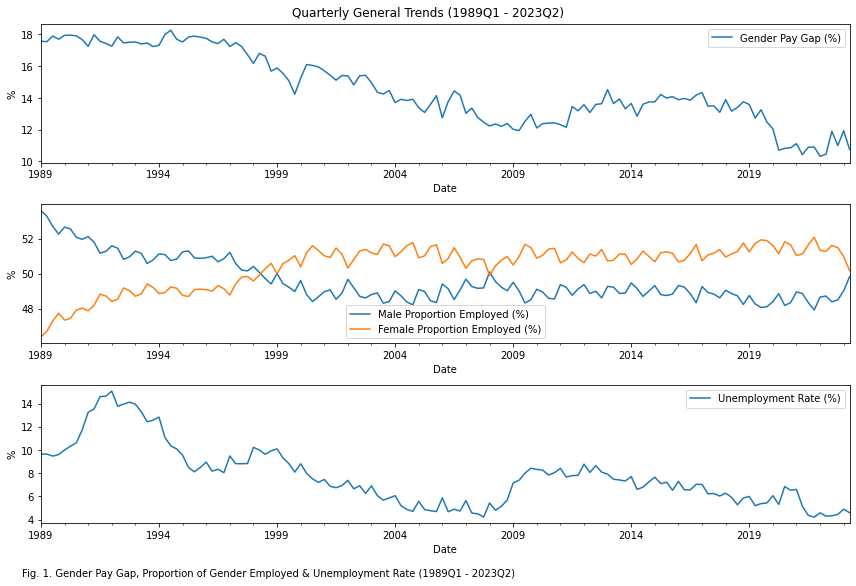

In [4]:
import matplotlib.pyplot as plt

# Create a figure and specify the number of subplots
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(12, 8))

# Plot each column against the index (Date) on separate subplots
VAR_variables['Pay Gap (%)'].plot(ax=axes[0], label='Gender Pay Gap (%)')
axes[0].set_ylabel('%')  # Add x-axis label to the first subplot

VAR_variables['Male Proportion Employed (%)'].plot(ax=axes[1], label='Male Proportion Employed (%)')
VAR_variables['Female Proportion Employed (%)'].plot(ax=axes[1], label='Female Proportion Employed (%)')
axes[1].set_ylabel('%')  # Add x-axis label to the second subplot

VAR_variables['Unemployment Rate (%)'].plot(ax=axes[2], label='Unemployment Rate (%)')
axes[2].set_ylabel('%')  # Add x-axis label to the third subplot

# Add legends to each subplot
axes[0].legend()
axes[1].legend()
axes[2].legend()

# Add a single overall title above the subplots
fig.suptitle("Quarterly General Trends (1989Q1 - 2023Q2)", y=0.97, ha='center')

# Add a caption in the bottom right corner
caption_text = "Fig. 1. Gender Pay Gap, Proportion of Gender Employed & Unemployment Rate (1989Q1 - 2023Q2)"
fig.text(0.6, -0.02, caption_text, ha='right')

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()



**Key Features**

- **Gender Pay Gap:** Calculated using Formula 1, the pay gap represents the percentage disparity in earnings between genders.

- **Gender Proportion Employed:** Calculated using Formula 3, the gender proportion signifies the percentage of either males or females employed relative to the total workforce.

- **Unemployment Rate:** Calculated using Formula 2, the unemployment rate signifies the percentage of the workforce capable of working who are currently unemployed.

**Key Observations**

**Pay Gap**
- The Pay Gap exhibits dynamic trends with periodic fluctuations.
- Notably, the pay gap remained relatively stable from 1989 to 1997. Subsequently, it generally shows a declining trend.
- A significant drop in the Pay Gap occurred in early 2020, possibly due to the impact of the COVID-19 pandemic.
- Another noteworthy decrease in the Pay Gap occurred in late 1999.

**Gender Proportion**
- Gender proportions appear to follow a seasonal pattern, with male employment rising at the beginning of the year and decreasing during the middle quarters, possibly reflecting seasonal employment patterns.
- The two gender proportion lines mirror each other, indicating that an increase in male employment corresponds to a decrease in female employment.
- Since 1989Q2, there has consistently been a higher proportion of females employed than males, with the exception of 2008.

**Unemployment Rate**
- The unemployment rate experienced a significant peak around 1990, likely reflecting the impact of the "Early 1990s Recession."
- Another notable peak occurred around 2009, which may be attributed to the "Great Recession."
- A more recent peak is evident around 2021, likely associated with the COVID-19 pandemic.
- Overall, the unemployment rate has seen a significant decrease in 2023 compared to its initial rate in 1989.

**Comparisons**

By utilizing a MinMax scaler, the values of each variable are transformed to a common scale ranging from 0 to 1. This scaling process is beneficial because it enables direct comparisons between variables, regardless of their original ranges. When variables have different units or significantly different value ranges, comparing them directly can be challenging and may lead to skewed interpretations. The MinMax scaling ensures that each variable's values are proportionally mapped to the [0, 1] range, preserving their relative relationships while making them directly comparable.

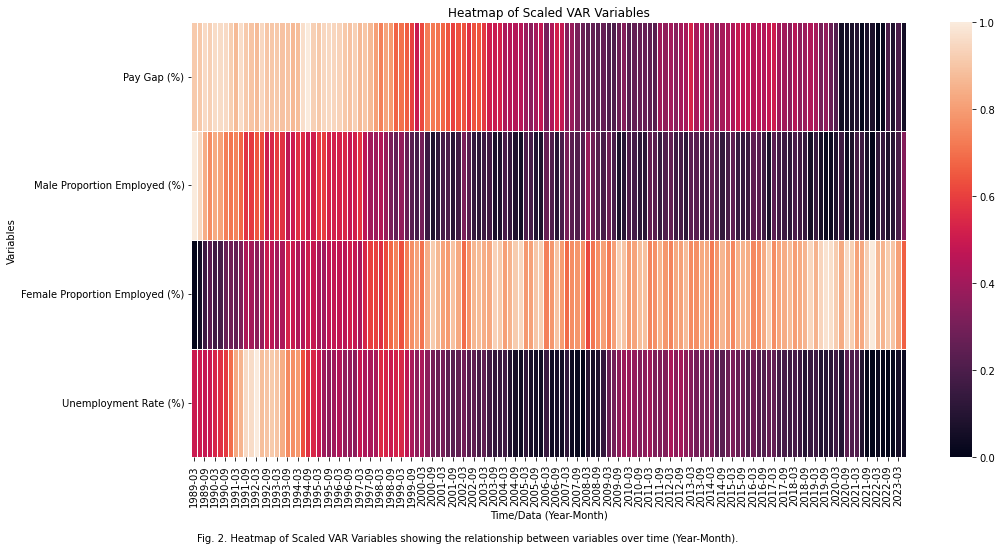

In [5]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns

# Create a MinMaxScaler object
scaler = MinMaxScaler()

# Fit the scaler to your DataFrame and transform the data
scaled_data = scaler.fit_transform(VAR_variables)

# Create a new DataFrame with the scaled data
scaled_df = pd.DataFrame(scaled_data, columns=VAR_variables.columns, index=VAR_variables.index)

# Assuming you have already defined scaled_df
plt.figure(figsize=(16, 8))

# Create a copy of the scaled DataFrame with a new column for formatted dates
scaled_df_copy = scaled_df.copy()
scaled_df_copy['Formatted Date'] = pd.to_datetime(scaled_df_copy.index).strftime('%Y-%m')

# Create the heatmap with the formatted date column as the x-axis
ax = sns.heatmap(scaled_df_copy.set_index('Formatted Date').transpose(), fmt=".2f", linewidths=0.8)

plt.title('Heatmap of Scaled VAR Variables')
plt.xlabel('Time/Data (Year-Month)')
plt.ylabel('Variables') # Rotate x-axis labels for better visibility

# Add a caption in the bottom right corner
caption_text = "Fig. 2. Heatmap of Scaled VAR Variables showing the relationship between variables over time (Year-Month)."
plt.figtext(0.6, -0.02, caption_text, ha='right', fontsize=10)

plt.show()


**Key Observations**

A notable observation is that the female proportion of employment has remained close to its maximum since around 1999, while the male proportion of employment has consistently remained near its minimum. These two measures have shown minimal progress towards reaching their respective maximum or minimum values.

Another observation is that since the female proportion of employment has been close to its minimum since around 1999, the unemployment rate has consistently remained low. All values exceeding approximately 0.5 appear to be before this period.

When comparing the Gender Pay Gap and Gender Proportion, an interesting observation emerges. Prior to 1999, the Gender Pay Gap remained relatively stagnant. Coincidentally, this period aligns with the time when the proportion of female workers surpassed that of male workers. Subsequently, a noteworthy trend emerges: the Gender Pay Gap consistently trends downward.

**Auto Correlations**

In order to construct an effective VAR (Vector Autoregressive) time series model, it's crucial to have a deep understanding of how individual data points relate to one another. 

Autocorrelation plots provide valuable insights into the extent of correlation between a data point and its past values, often referred to as "lags." Lags represent data points that occurred in earlier time periods. For instance, a lag of 2 means we are looking at data points from two time periods before the current one.

Since this study primarily focuses on the gender pay gap and male employment, we will investigate these specific features.

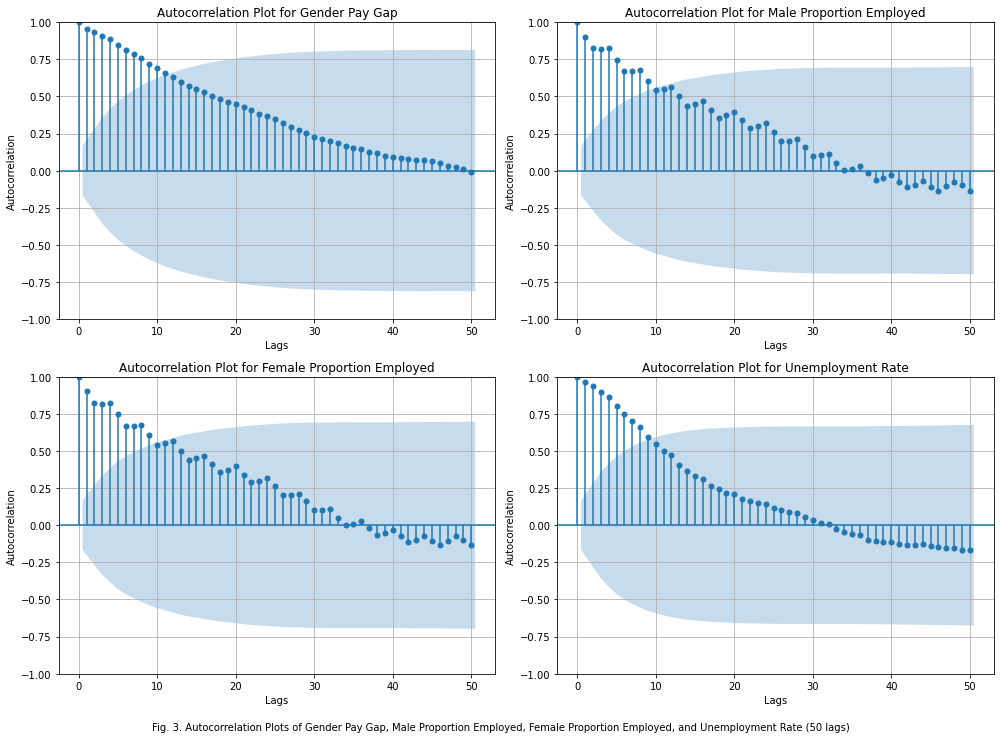

In [6]:
# Create a 2x2 grid of subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot the autocorrelation for 'Pay Gap (%)' on the first subplot
plot_acf(VAR_variables['Pay Gap (%)'], lags=50, ax=axes[0, 0])
axes[0, 0].set_xlabel('Lags')
axes[0, 0].set_ylabel('Autocorrelation')
axes[0, 0].set_title('Autocorrelation Plot for Gender Pay Gap')
axes[0, 0].grid(True)

# Plot the autocorrelation for 'Male Proportion Employed (%)' on the second subplot
plot_acf(VAR_variables['Male Proportion Employed (%)'], lags=50, ax=axes[0, 1])
axes[0, 1].set_xlabel('Lags')
axes[0, 1].set_ylabel('Autocorrelation')
axes[0, 1].set_title('Autocorrelation Plot for Male Proportion Employed')
axes[0, 1].grid(True)

# Plot the autocorrelation for 'Female Proportion Employed (%)' on the third subplot
plot_acf(VAR_variables['Female Proportion Employed (%)'], lags=50, ax=axes[1, 0])
axes[1, 0].set_xlabel('Lags')
axes[1, 0].set_ylabel('Autocorrelation')
axes[1, 0].set_title('Autocorrelation Plot for Female Proportion Employed')
axes[1, 0].grid(True)

# Plot the autocorrelation for 'Unemployment Rate (%)' on the fourth subplot
plot_acf(VAR_variables['Unemployment Rate (%)'], lags=50, ax=axes[1, 1])
axes[1, 1].set_xlabel('Lags')
axes[1, 1].set_ylabel('Autocorrelation')
axes[1, 1].set_title('Autocorrelation Plot for Unemployment Rate')
axes[1, 1].grid(True)

# Adjust layout
plt.tight_layout()

# Add a caption to the figure
fig.text(0.5, -0.02, 'Fig. 3. Autocorrelation Plots of Gender Pay Gap, Male Proportion Employed, Female Proportion Employed, and Unemployment Rate (50 lags)',
         ha='center')

# Show the plots
plt.show()



**Features**
- This plot delves into the correlation between the current data point while considering the impact of values that occurred in the intervening periods.
- The term "50 lags" signifies the inclusion of data points that date back up to 50 time periods before the current data point.
- The shaded blue area represents error bands, which establish a 95% confidence interval by default. Data points falling outside of this area are deemed statistically significant.

**Key Observations**
- Notably, up to 11 lags exhibit statistical significance for the gender pay gap, while 9 lags show significance for both male and female proportions employed, as well as the unemployment rate.

- The gender pay gap displays a consistently declining linear correlation pattern, indicating a gradual decrease over time.

- Gender proportions appear to exhibit a clear seasonal relationship, with correlations showing periodic increases and decreases, likely reflecting annual patterns. 
- Negative correlations emerge for the proportion plots around 34 lags, while for the unemployment rate, negativity in correlations becomes evident around 32 lags.

The analysis shows that correlations between the variables of interest and their past values remain statistically significant up to 9 lags. This implies that these lagged values contain meaningful information and are relevant for predicting future values of the variables.

### Vector Autoregression (VAR)

One limitation of standard time series models is they impose a unidirectional relationship - the forecast variable is influenced by the predictor variables but not vice versa (Hyndman, Athanasopoulos, 2018). A VAR model is an extension of the univariate autoregressive model, designed for predicting outcomes in a multivariate time series. It consists of one equation for each variable within the system. In each equation, the right side contains a constant term and lagged values of all the variables present in the system.

In this example, a two-dimensional VAR model is analyzed, with the dimensions denoting the Gender Pay Gap and Total Employment. To express a one-lag system, where $y_1$ signifies the Gender Pay Gap and $y_2$ stands for Total Male Employment, the formula is as follows:


$$ y_{1,t} = c_1 + \Phi_{11,1}y_{1,t-1} + \phi_{12,1}y_{2,t-1} + e_{1,t} $$
$$ y_{2,t} = c_2 + \Phi_{21,1}y_{1,t-1} + \phi_{22,1}y_{2,t-1} + e_{1,t} $$

In the given context, there are two white noise processes, denoted as $e_{1,t}$ and $e_{2,t}$, which may exhibit contemporaneous correlation (Hyndman, Athanasopoulos, 2018). 

The coefficient $\phi_{i,i,\ell}$ represents the impact of the $\ell$-th lag of variable $y_i$ on itself, while the coefficient $\phi_{i,j,\ell}$ signifies the effect of the $\ell$-th lag of variable $y_j$ on $y_i$( Hyndman, Athanasopoulos, 2018).

By examining the influence of lagged variables $y_i$ on variable $y_j$, statistical conclusions regarding whether Male Total Employment has an impact on the Gender Pay Gap can be drawn.

**Stationarity**

When dealing with stationary time series data, forecasts are created by directly modeling a VAR (Vector Autoregressive) using the original data, referred to as a "VAR in levels." However, if the time series are non-stationary, differences of the data are taken to achieve stationarity, and then a VAR model is constructed, known as a "VAR in differences." In both cases, the model parameters are estimated equation by equation using the least squares method, with the goal of minimizing the sum of squared $e_{i,t}$ values (Hyndman, Athanasopoulos, 2018).


**Augmented Dickey Fuller Test**

The augmented Dickey-Fuller test is an extension of the standard Dickey-Fuller test, which checks for both stationarity and non-stationarity in the time series.

To examine stationarity, we employ the augmented Dickey-Fuller test with the following hypotheses:

1. The null hypothesis states that there exists a unit root in the time series and is non-stationary.

2. The alternative hypothesis states that there exists no unit root in the time series and is stationary or trend stationary


<brk>

In [7]:
print( "Pay Gap Augmented Dicky Fuller P-value:", adfuller(VAR_variables['Pay Gap (%)'])[1].round(3))
print( "Male Proportion Employed Augmented Dicky Fuller P-value:", adfuller(VAR_variables['Male Proportion Employed (%)'])[1].round(3))
print( "Female Proportion Employed Augmented Dicky Fuller P-value:", adfuller(VAR_variables['Female Proportion Employed (%)'])[1].round(3))
print( "Unemployment Rate Augmented Dicky Fuller P-value:", adfuller(VAR_variables['Unemployment Rate (%)'])[1].round(3))

Pay Gap Augmented Dicky Fuller P-value: 0.731
Male Proportion Employed Augmented Dicky Fuller P-value: 0.215
Female Proportion Employed Augmented Dicky Fuller P-value: 0.214
Unemployment Rate Augmented Dicky Fuller P-value: 0.187


Given that the p-value exceeds 0.05 in all cases, the alternative hypothesis is rejected. This implies that all sets of data are non-stationary. To address this issue, the previously mentioned method of differencing the data to achieve stationarity is utilized. This involves subtracting the value at time (t-1) from the data point at time (t).

**Differenced Data Augmented Dickey Fuller Test**

In [8]:
print( "Pay Gap Augmented Dicky Fuller P-value:", adfuller(VAR_variables['Pay Gap (%)'].diff()[1:])[1].round(3))
print( "Male Proportion Employed Augmented Dicky Fuller P-value:", adfuller(VAR_variables['Male Proportion Employed (%)'].diff()[1:])[1].round(3))
print( "Female Proportion Employed Augmented Dicky Fuller P-value:", adfuller(VAR_variables['Female Proportion Employed (%)'].diff()[1:])[1].round(3))
print( "Unemployment Rate Augmented Dicky Fuller P-value:", adfuller(VAR_variables['Unemployment Rate (%)'].diff()[1:])[1].round(3))




Pay Gap Augmented Dicky Fuller P-value: 0.0
Male Proportion Employed Augmented Dicky Fuller P-value: 0.093
Female Proportion Employed Augmented Dicky Fuller P-value: 0.094
Unemployment Rate Augmented Dicky Fuller P-value: 0.001


In this context, the p-values for Pay Gap and the Unemployment rate are less than 0.05, indicating significant results that warrant the rejection of the null hypothesis in these instances. This suggests that the data has achieved stationarity, making it suitable for VAR modeling. However, in the case of gender proportions, the p-values exceed 0.05. This is likely due to the seasonal trend observed during exploratory data analysis. Since this trend appears to occur annually, the approach will be to address it by applying the annual difference for these features, subtracting the 4th lag from the current data point.

**Seasonally Differenced Augmented Dickey Fuller Test**

In [9]:
VAR_variables["seasonally differenced_male"] = (VAR_variables['Male Proportion Employed (%)'] - VAR_variables['Male Proportion Employed (%)'].shift(4)).round(3)
VAR_variables["seasonally differenced_female"]  = (VAR_variables['Female Proportion Employed (%)'] - VAR_variables['Female Proportion Employed (%)'].shift(4)).round(3)

VAR_variables["seasonally differenced_male"].dropna()
VAR_variables["seasonally differenced_female"].dropna()


print("Male Proportion Employed Augmented Dickey Fuller P-value:", adfuller(VAR_variables["seasonally differenced_male"].dropna()[1:])[1])
print("Female Proportion Employed Augmented Dickey Fuller P-value:", adfuller(VAR_variables["seasonally differenced_female"].dropna()[1:])[1])      
      

Male Proportion Employed Augmented Dickey Fuller P-value: 0.05212490150949364
Female Proportion Employed Augmented Dickey Fuller P-value: 0.0522720256825169


Seasonal differencing results in p-value approximately < 0.05 indicating significant results that allow us to reject the null hypothesis. This suggests the at this data has achieved stationarity making it suitable for VAR modeling.

**Granger Causality Test**

Next, Granger Causality tests will be employed to examine whether the proportion of gender employed or the unemployment rate has an association with the Gender Pay Gap. Up to four lags will be investigated with the following hypotheses:

1. Null Hypothesis: The lagged values of the variable do not have an association with the target variable.
2. Alternative Hypothesis: The lagged values of the variable do have an association with the target variable.

In [10]:
VAR_variables['Pay Gap Difference'] = VAR_variables["Pay Gap (%)"].diff()
VAR_variables['Unemployment Rate Difference'] = VAR_variables["Unemployment Rate (%)"].diff()

seasonal_index = VAR_variables.tail(133)


print('Table 2: Granger Causality Results - Annually Differenced Male Proportion of Employment Association with 1 Lag Differenced Gender Pay Gap')
import pandas as pd

data = {
    'Number of Lags': [1, 2, 3, 4],
    'P-Value': [0.0378, 0.1052, 0.2173, 0.3750]
}

df = pd.DataFrame(data)

df


Table 2: Granger Causality Results - Annually Differenced Male Proportion of Employment Association with 1 Lag Differenced Gender Pay Gap


,Number of Lags,P-Value
0,1,0.0378
1,2,0.1052
2,3,0.2173
3,4,0.3750


In [11]:
print('Table 3: Granger Causality Results - Annually Seasonally Differenced Female Proportion of Employment Association with 1 Lag Differenced Gender Pay Gap')

import pandas as pd

data = {
    'Number of Lags': [1, 2, 3, 4],
    'P-Value': [0.0376, 0.1086, 0.2233, 0.3873]
}

df = pd.DataFrame(data)

df


Table 3: Granger Causality Results - Annually Seasonally Differenced Female Proportion of Employment Association with 1 Lag Differenced Gender Pay Gap


,Number of Lags,P-Value
0,1,0.0376
1,2,0.1086
2,3,0.2233
3,4,0.3873


In [12]:
print('Table 4: Granger Causality Results - 1 Lag Differenced Unemployment Rate Association with with 1 Lag Difference Gender Pay Gap')
import pandas as pd

data = {
    'Number of Lags': [1, 2, 3, 4],
    'P-Value': [0.7953, 0.6481, 0.6034, 0.7232]
}

df = pd.DataFrame(data)

df



Table 4: Granger Causality Results - 1 Lag Differenced Unemployment Rate Association with with 1 Lag Difference Gender Pay Gap


,Number of Lags,P-Value
0,1,0.7953
1,2,0.6481
2,3,0.6034
3,4,0.7232


With p-values < 0.05 for one-lag associations with both female and male proportion of employment, these relationships with the Gender Pay Gap are statistically significant, allowing us to reject the null hypothesis. However, for all other lag values, the results are not significant. In the case of unemployment, all lag values have p-values > 0.05, indicating that there is no significant association between these lags and the gender pay gap. Due to p-values being sufficiently larger then 0.05 unemployment will not be used in the model.

**Modeling Vector Auto Regression**

Having successfully transformed the data into a stationary form and established a relationship between the proportion of male & female in employment and the Gender Pay Gap, we now aim to select the most suitable VAR (Vector Autoregressive) model.

To determine the optimal number of lags for our model, we will utilize four scoring metrics: AIC (Akaike Information Criterion), BIC (Bayesian Information Criterion), FPE (Final Prediction Error), and HQIC (Hannan-Quinn Information Criterion). The optimal model will be characterized by the lowest scores across all these metrics. Our investigation will encompass models ranging from 1 to 4 lags.

In [13]:
print("Table 5: AIC, BIC, FPE, HQIC score for VAR(1) - VAR(4)")

VAR_variables = combined[selected_columns].copy()

VAR_variables = VAR_variables.drop(['Unemployment Rate (%)','Male Proportion Employed (%)'],axis=1)

train_df = VAR_variables[:-12]
test_df = VAR_variables[-12:]

model = VAR(train_df.diff()[1:])
sorted_model = model.select_order(maxlags=4)
print(sorted_model.summary())

Table 5: AIC, BIC, FPE, HQIC score for VAR(1) - VAR(4)
 VAR Order Selection (* highlights the minimums) 
      AIC         BIC         FPE         HQIC   
-------------------------------------------------
0      -3.194      -3.148     0.04100      -3.175
1      -3.274      -3.135     0.03786      -3.218
2      -3.693      -3.462     0.02489      -3.599
3      -3.816      -3.492     0.02203      -3.684
4     -4.057*     -3.641*    0.01731*     -3.888*
-------------------------------------------------


With the metrics AIC,BIC, FPE, and HQIC all reaching their minimum values when 4 lags are employed, it is evident that the VAR (Vector Autoregressive) model with 4 lags is the optimal choice. Consequently, this model will be the one utilized for our subsequent analysis.

**Fitted Model**

Using both male proportion and female proportion as variables in the model yielded unsatisfactory results, as none of the coefficients were statistically significant. This lack of significance is likely attributed to the high correlation between these variables. Consequently, a new model was constructed using only the female proportion variable, which yielded more statistically significant results.

**Results for Equation Gender Pay Gap**

In [14]:
import pandas as pd

data = {
    'Variable': ['intercept', 'L1.Pay Gap (%)', 'L1.Female Proportion Employed (%)', 'L2.Pay Gap (%)',
                 'L2.Female Proportion Employed (%)', 'L3.Pay Gap (%)', 'L3.Female Proportion Employed (%)',
                 'L4.Pay Gap (%)', 'L4.Female Proportion Employed (%)'],
    'Coef': [9.2739, 0.6136, 0.1292, 0.1592, -0.4683, -0.0187, 0.3342, 0.1449, -0.1508],
    'Std Err': [4.789, 0.095, 0.147, 0.106, 0.138, 0.116, 0.151, 0.096, 0.139],
    'z-score': [1.937, 6.432, 0.881, 1.500, -3.388, -0.161, 2.208, 1.509, -1.088],
    'P-Value': [0.053, 0.000, 0.378, 0.134, 0.001, 0.872, 0.027, 0.131, 0.277],
    '95% CI Lower': [-0.111, 0.427, -0.158, -0.049, -0.739, -0.247, 0.038, -0.043, -0.423],
    '95% CI Upper': [18.659, 0.801, 0.417, 0.367, -0.197, 0.210, 0.631, 0.333, 0.121]
}

df = pd.DataFrame(data)

print('Table 6: VAR Results for Gender Pay Gap')

df


Table 6: VAR Results for Gender Pay Gap


,Variable,Coef,Std Err,z-score,P-Value,95% CI Lower,95% CI Upper
0,intercept,9.2739,4.789,1.937,0.053,-0.111,18.659
1,L1.Pay Gap (%),0.6136,0.095,6.432,0.000,0.427,0.801
2,L1.Female Proportion Employed (%),0.1292,0.147,0.881,0.378,-0.158,0.417
3,L2.Pay Gap (%),0.1592,0.106,1.500,0.134,-0.049,0.367
4,L2.Female Proportion Employed (%),-0.4683,0.138,-3.388,0.001,-0.739,-0.197
5,L3.Pay Gap (%),-0.0187,0.116,-0.161,0.872,-0.247,0.210
6,L3.Female Proportion Employed (%),0.3342,0.151,2.208,0.027,0.038,0.631
7,L4.Pay Gap (%),0.1449,0.096,1.509,0.131,-0.043,0.333
8,L4.Female Proportion Employed (%),-0.1508,0.139,-1.088,0.277,-0.423,0.121


**Equation for Gender Pay Gap:**

$\Delta(Pay Gap_t) = 9.2739 + 0.6136\cdot(Pay Gap_{t-1}) + 0.1292\cdot(Female Proportion Employed_{t-1}) + 0.1592\cdot(Pay Gap_{t-2}) - 0.4683\cdot(Female Proportion Employed_{t-2}) - 0.0187\cdot(Pay Gap_{t-3}) + 0.3342\cdot(Female Proportion Employed_{t-3}) + 0.1449\cdot(Pay Gap_{t-4}) - 0.1508\cdot(Female Proportion Employed_{t-4})$


**Key Results**

The primary focus centers on the gender pay gap equation, where we have identified several key coefficients of significant statistical importance. Specifically, we've uncovered the following noteworthy findings:

1. The coefficient for the Pay Gap at a lag of 1 is 0.6136, indicating a strong quarterly relationship between the gender pay gap and its previous quarter, with a 95% confidence interval (CI) ranging from 0.427 to 0.801. The associated p-value is highly significant at 0.000.

2. Additionally, we have observed significant coefficients associated with the Female Proportion Unemployed at lags 2 and 3:

   - The coefficient for the Female Proportion Unemployed at lag 2 is -0.4683, suggesting a quarterly relationship between the gender pay gap and female unemployment two quarters prior. The 95% CI spans from -0.739 to -0.197, and the p-value is 0.001. This also signifies a strong negative relationship between this variable and this pay gap, signifying if the female proportion increases during this lag the pay gap will shrink.

   - The coefficient for the Female Proportion Unemployed at lag 3 is 0.3342, indicating a three-quarter association with the pay gap. The 95% CI ranges from 0.038 to 0.631, and the p-value is 0.038. This also signifies a strong positive relationship between this variable and this pay gap, signifying that if female proportion increases during this lag the pay gap will grow.

These coefficients provide critical insights into our analysis of the gender pay gap, revealing both short-term and longer-term relationships with important variables such as the pay gap itself and female unemployment rates.

<br>

**Conclusion**

This analysis aimed to explore the relationship between gender employment proportions, unemployment rates, and the gender pay gap.

One hypothesis suggested that "proportion of males employed" and "proportion of females employed" could influence the pay gap by affecting access to high-paying roles or income distribution. Our findings supported this idea, with significant associations between gender proportions and the gender pay gap. The vector autoregression analysis showed statistically significant coefficients for Pay Gap at a lag of 1 and Female Proportion Unemployed at lags 2 and 3, indicating notable quarterly changes.

Another hypothesis examined the role of the unemployment rate, especially in male-dominated sectors prone to specific industry job losses during economic fluctuations. Surprisingly, our analysis did not reveal a significant link between employment rates and the gender pay gap. Granger Causality tests supported this by returning p-values greater than 0.05, indicating no association between lagged versions of the gender pay gap.

**Recommendations**

The insights from this analysis suggest considering gender proportion in any "adjusted pay gap" investigation, given its meaningful association with the gender pay gap. However, it's crucial to acknowledge that the gender pay gap is a multifaceted issue influenced by various economic, social, and organizational factors. Therefore, while gender proportion demonstrates a significant connection, it should be examined alongside other potential contributors, such as education, industry, job roles, and policies, to understand the pay gap comprehensively and formulate effective solutions.

**Limitations**

Our analysis has limitations, including data availability and the quarterly data nature. Quarterly data may miss subtle trends. Additionally, the study does not delve deeply into complex factors like education, industry, and organizational policies, which can influence the gender pay gap. Limited time, resources, and knowledge due to the project's short duration were constraints.

<br>

**Summary**

In summary, the association between gender employment proportions and the gender pay gap provides valuable insights. Additionally, the absence of a connection between unemployment and the gender pay gap was an interesting finding. Future research should consider various factors and variables to explore the gender pay gap further. Exploring data at a unit level could reveal subtler trends, improving our understanding of this persistent issue.

### References


- Creative Commons. Attribution 4.0 International(CC BY 4.0). https://creativecommons.org/licenses/by/4.0/
- Ministry for Women (n.d). The gender pay gap. https://women.govt.nz/women-and-work/genderpay-gap
- Our World in Data (2018). Economic inequality by gender. https://ourworldindata.org/economicinequality-by-gender#the-gender-pay-gap-across-countries-and-over-time
- Public Service Commission (n.d). Te utu rite me ng puta (Pay gaps and pay equity). https://www.
publicservice.govt.nz/system/public-service-people/pay-gaps-and-pay-equity/#:~:text=This%20is%20particularly%20
- StatsNZ. (2014). Measuring the gender pay gap. https://www.stats.govt.nz/assets/Uploads/Retirement-of-archive-website-project-files/Methods/Measuring-the-gender-pay-gap/measuringgender-pay-gap.pdf
- StatsNZ. (2016). About the Quarterly Employment Survey. https://www.stats.govt.nz/help-withsurveys/list-of-stats-nz-surveys/about-the-quarterly-employment-survey/
- StatsNZ. (2021). Copyright. Stats NZ. https://www.stats.govt.nz/about-us/copyright/

- StatsNZ. (2021). Privacy. Stats NZ. https://www.stats.govt.nz/about-us/privacy-statement/.

- StatsNZ. (2023). About the Household Labour Force Survey https://www.stats.govt.nz/help-with-surveys/list-of-stats-nz-surveys/about-the-household-labour-force-survey/
- StatsNZ. (n.d) Employment and unemployment https://www.stats.govt.nz/topics/employment-and-unemployment

- Hyndman, Athanasopoulos (2018), “Forecasting: Principles and Practice” - Rob J Hyndman and George Athanasopoulos; Monash University, Australia. https://otexts.com/fpp2/